## Continuing on from 3

In [2]:
import os, sys
import copy as copyroot
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt
from fastai2.basics import *
from fastai2.vision.all import *
%load_ext autoreload
%autoreload 2
from module.mnist_helpers import build_df, eda_fig_1, build_dls

In [3]:
dls = build_dls(target='topleft')
x, y = dls.one_batch()
x.shape

torch.Size([64, 1, 28, 28])

### Visualize the observation and expanded feature set
"expanded feature set" created via argmin/argmax

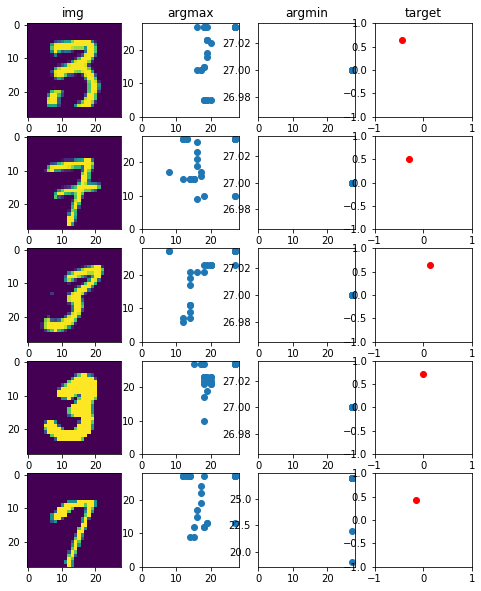

In [4]:
rows = 5
cols = 4

fig, ax = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
for i in range(rows):
    ax[i][0].imshow(x[i].squeeze(0))
    ax[i][1].scatter(x[i].argmax(2), x[i].argmax(1))
    ax[i][1].set_xlim(0,28); ax[i][1].set_ylim(0,28)
    ax[i][2].scatter(x[i].argmin(2), x[i].argmin(1))
    ax[i][2].set_xlim(0,28); ax[i][1].set_ylim(0,28)
    
    ax[i][3].scatter(y[i,0,0], -1.* y[i,0,1], c='red')
    ax[i][3].set_xlim(-1,1); ax[i][3].set_ylim(-1,1)
    
    if i == 0:
        ax[i][0].set_title('img')
        ax[i][1].set_title('argmax')
        ax[i][2].set_title('argmin')
        ax[i][3].set_title('target')
        


### Build Better Feature Set

In [5]:
xi = x[0].squeeze(0)

nz   = xi.nonzero()

mins = nz.min(0)
maxs = nz.max(0)

mm    = torch.stack((mins.values, maxs.values))

mm2 = torch.stack((
torch.cat((
    torch.tensor([nz[nz[:,1] == e].max(0).values[0] for e in mm[:,1]]),
    torch.tensor([nz[nz[:,1] == e].min(0).values[0] for e in mm[:,1]])

)),
torch.cat((
    torch.tensor([nz[nz[:,0] == e].max(0).values[1] for e in mm[:,0]]),
    torch.tensor([nz[nz[:,0] == e].min(0).values[1] for e in mm[:,0]])
))
))
mm2 = mm2.T

In [6]:
mm

tensor([[ 5,  6],
        [24, 21]])

In [7]:
mm2

tensor([[24, 20],
        [20, 19],
        [20,  8],
        [17,  6]])

In [8]:
def pt_feats(i, combo='12'):
    
    xi = x[i].squeeze(0)

    nz   = xi.nonzero()

    mins = nz.min(0)
    maxs = nz.max(0)

    mm    = torch.stack((mins.values, maxs.values))

    mm2 = torch.stack((
    torch.cat((
        torch.tensor([nz[nz[:,1] == e].max(0).values[0] for e in mm[:,1]]),
        torch.tensor([nz[nz[:,1] == e].min(0).values[0] for e in mm[:,1]])
    )),
    torch.cat((
        torch.tensor([nz[nz[:,0] == e].max(0).values[1] for e in mm[:,0]]),
        torch.tensor([nz[nz[:,0] == e].min(0).values[1] for e in mm[:,0]])
    ))
    ))
    mm2 = mm2.T
    
    if combo == '11':
        pts11 = torch.cartesian_prod(mm[:,0], mm[:,1])
        return pts11
        
    if combo == '12':
        pts12 = torch.cat((
            torch.cartesian_prod(mm[:,0],  mm2[:,1]),
            torch.cartesian_prod(mm2[:,0], mm[:,1])
        ))
        return pts12
    
    if combo == '22':
        pts22 = torch.cartesian_prod(mm2[:,0], mm2[:,1])        
        return pts22


In [9]:
len(pt_feats(0, combo='11')),len(pt_feats(0, combo='12')), len(pt_feats(0, combo='22'))

(4, 16, 16)

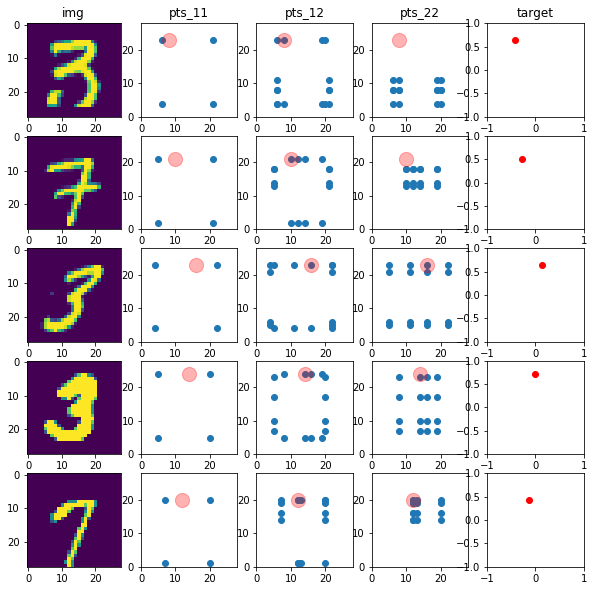

In [10]:
rows = 5
cols = 5

fig, ax = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
for i in range(rows):
    
    ax[i][0].imshow(x[i].squeeze(0))
    
    pts = pt_feats(i, combo='11')
    ax[i][1].scatter(pts[:,1], 28-pts[:,0])
    ax[i][1].scatter(14+(y[i,0,0]*14), 14+(-14.* y[i,0,1]), c='red', alpha=0.3, s=200)
    ax[i][1].set_xlim(0,28); ax[i][1].set_ylim(0,28)
    
    pts = pt_feats(i, combo='12')
    ax[i][2].scatter(pts[:,1], 28-pts[:,0])
    ax[i][2].scatter(14+(y[i,0,0]*14), 14+(-14.* y[i,0,1]), c='red', alpha=0.3, s=200)
    ax[i][2].set_xlim(0,28); ax[i][2].set_ylim(0,28)
    
    
    pts = pt_feats(i, combo='22')
    ax[i][3].scatter(pts[:,1], 28-pts[:,0])
    ax[i][3].scatter(14+(y[i,0,0]*14), 14+(-14.* y[i,0,1]), c='red', alpha=0.3, s=200)
    ax[i][3].set_xlim(0,28); ax[i][3].set_ylim(0,28)
    

    ax[i][4].scatter(y[i,0,0], -1.* y[i,0,1], c='red')
    ax[i][4].set_xlim(-1,1); ax[i][4].set_ylim(-1,1)
    
    if i == 0:
        ax[i][0].set_title('img')
        ax[i][1].set_title('pts_11')
        ax[i][2].set_title('pts_12')
        ax[i][3].set_title('pts_22')
        ax[i][4].set_title('target')
        


It seems pts_12 is expressive enough to capture the target.

Interesting... it looks like I could do digit classification on these features:

Comparing pts_12 to pts_22, 3 and 7 exibit different relative patterns, where the 7 tightly contains its 22 points in the upper half of the region enclosed by its 11 points, while for 3 there are multiple clusters of regions.

### Build a NN with a variable amount of features

TODO - do standard scaling on min/max features

In [11]:
def build_pt_feats(x, combo='12'):
    
    xi = x.squeeze(0)

    nz   = xi.nonzero()

    mins = nz.min(0)
    maxs = nz.max(0)

    mm    = torch.stack((mins.values, maxs.values))

    mm2 = torch.stack((
    torch.cat((
        torch.tensor([nz[nz[:,1] == e].max(0).values[0] for e in mm[:,1]]),
        torch.tensor([nz[nz[:,1] == e].min(0).values[0] for e in mm[:,1]])
    )),
    torch.cat((
        torch.tensor([nz[nz[:,0] == e].max(0).values[1] for e in mm[:,0]]),
        torch.tensor([nz[nz[:,0] == e].min(0).values[1] for e in mm[:,0]])
    ))
    ))
    mm2 = mm2.T
    
    if combo == '11':
        pts11 = torch.cartesian_prod(mm[:,0], mm[:,1])
        return pts11
        
    if combo == '12':
        pts12 = torch.cat((
            torch.cartesian_prod(mm[:,0],  mm2[:,1]),
            torch.cartesian_prod(mm2[:,0], mm[:,1])
        ))
        return pts12
    
    if combo == '22':
        pts22 = torch.cartesian_prod(mm2[:,0], mm2[:,1])        
        return pts22


In [12]:
build_pt_feats(x[0])

tensor([[ 5, 20],
        [ 5, 19],
        [ 5,  8],
        [ 5,  6],
        [24, 20],
        [24, 19],
        [24,  8],
        [24,  6],
        [24,  6],
        [24, 21],
        [20,  6],
        [20, 21],
        [20,  6],
        [20, 21],
        [17,  6],
        [17, 21]])

In [15]:
class FeatsNet(torch.nn.Module):
    
    def __init__(self, D_in=28, H=28, feats=['pix']):
        
        self.feats = feats
        self.D = D_in
        
        super(FeatsNet, self).__init__()
        
        len_ins = 0
        if 'pix'      in self.feats: len_ins += D_in**2
        if 'max'      in self.feats: len_ins += D_in*2
        if 'min'      in self.feats: len_ins += D_in*2
        if 'pts11'    in self.feats: len_ins += 4*2
        if 'pts12'    in self.feats: len_ins += 16*2
        if 'pts22'    in self.feats: len_ins += 16*2
            
        if len_ins == 0: 
            raise Exception('Need a valid code in `feats`')
            
        self.flat    = nn.Flatten()
        
        self.linear1 = nn.Linear(in_features=len_ins, out_features=H)
        self.linear2 = nn.Linear(in_features=H,       out_features=2, 
                                 bias=False)
        
        self.sig     = SigmoidRange(-1., 1)
        
    def build_feats(self, x):
        
        l0 = torch.tensor([])
        
        if 'pix' in self.feats:
            l0 = self.flat(x)
        
        if 'max' in self.feats:
            max2  = self.flat(x.argmax(dim=2).float()) / float(self.D)
            max3  = self.flat(x.argmax(dim=3).float()) / float(self.D)
            l0 = torch.cat((l0, max2, max3), dim=1)
            
        if 'min' in self.feats:    
            min2  = self.flat(x.argmin(dim=2).float()) / float(self.D)
            min3  = self.flat(x.argmin(dim=3).float()) / float(self.D)
            l0 = torch.cat((l0, min2, min3), dim=1)
            
        if 'pts11' in self.feats:
            tmp = torch.tensor([build_pt_feats(e, combo='11').tolist() 
                                for e in x])
            pts = self.flat(tmp.float()) / float(self.D)
            l0 = torch.cat((l0, pts), dim=1)
        
        if 'pts12' in self.feats:
            tmp = torch.tensor([build_pt_feats(e, combo='12').tolist() 
                                for e in x])
            pts = self.flat(tmp.float()) / float(self.D)
            l0 = torch.cat((l0, pts), dim=1)
            
        if 'pts22' in self.feats:
            tmp = torch.tensor([build_pt_feats(e, combo='22').tolist() 
                                for e in x])
            pts = self.flat(tmp.float()) / float(self.D)
            l0 = torch.cat((l0, pts), dim=1)
            
        
            
        return l0
    
    def forward(self, x):
        
        l0 = self.build_feats(x)
        
        l1 = self.linear1(l0)
        l2 = self.linear2(l1)
        y =  self.sig(l2)
        return y

##### Show the change in feature size based on inputs requested in `feats`

In [16]:
def fn_info(feats):
    fn = FeatsNet(feats=feats)
    x2_feats = fn.build_feats(x)
    print(f'feats: {str(feats).ljust(25)} | {x2_feats.shape}')

feats = ['pix',]
fn_info(feats)

feats = ['pix', 'min', 'max']
fn_info(feats)

feats = ['pix', 'pts12']
fn_info(feats)

feats: ['pix']                   | torch.Size([64, 784])
feats: ['pix', 'min', 'max']     | torch.Size([64, 896])
feats: ['pix', 'pts12']          | torch.Size([64, 816])


##### Run Sample Models
With original feature set vs. expanded featrue set  

In [219]:
fn = FeatsNet(feats=['pix'])
learn = Learner(dls, fn, loss_func=MSELossFlat())
learn.fit(10)

epoch,train_loss,valid_loss,time
0,0.128537,0.036792,00:01
1,0.079495,0.040260,00:01
2,0.063951,0.038699,00:01
3,0.053110,0.026236,00:01
4,0.045499,0.025530,00:01
5,0.039770,0.024399,00:01
6,0.035366,0.022721,00:01
7,0.031768,0.022291,00:01
8,0.028938,0.021477,00:01
9,0.026546,0.021407,00:01


In [227]:
fn = FeatsNet(feats=['pix','pts12'])
learn = Learner(dls, fn, loss_func=MSELossFlat())
learn.fit(10)

816


epoch,train_loss,valid_loss,time
0,0.077677,0.040995,00:02
1,0.059086,0.041066,00:02
2,0.047420,0.024317,00:02
3,0.039556,0.025390,00:02
4,0.034113,0.020430,00:02
5,0.029894,0.020138,00:02
6,0.026614,0.018547,00:02
7,0.023918,0.018448,00:02
8,0.021766,0.017247,00:02
9,0.019926,0.017305,00:02


In [228]:
learn.fit(20)

epoch,train_loss,valid_loss,time
0,0.011329,0.016286,00:02
1,0.010885,0.015381,00:02
2,0.010495,0.017362,00:02
3,0.010241,0.015698,00:02
4,0.009935,0.014458,00:02
5,0.009658,0.014463,00:02
6,0.009442,0.015353,00:02
7,0.009140,0.015554,00:02
8,0.008834,0.013825,00:02
9,0.008598,0.013733,00:02


In [229]:
learn.fine_tune(20)

epoch,train_loss,valid_loss,time
0,0.005244,0.016229,00:02


epoch,train_loss,valid_loss,time
0,0.005439,0.012711,00:02
1,0.005158,0.012052,00:02
2,0.005179,0.013225,00:02
3,0.005088,0.014076,00:02
4,0.005106,0.012507,00:02
5,0.005067,0.012128,00:02
6,0.004939,0.011884,00:02
7,0.004832,0.012046,00:03
8,0.004775,0.014263,00:02
9,0.004675,0.012496,00:02


In [230]:
preds = learn.get_preds()

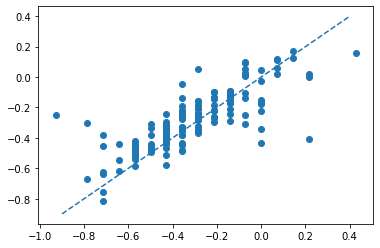

In [232]:
plt.scatter(preds[1].view(-1,2)[:,0], preds[0][:,0], )
plt.plot([-.9,.4],[-.9,.4], linestyle='--')

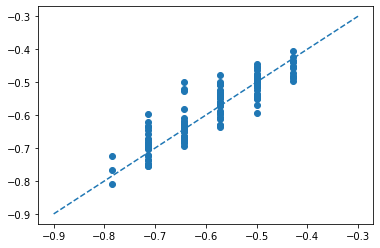

In [234]:
plt.scatter(preds[1].view(-1,2)[:,1], preds[0][:,1], )
plt.plot([-.9,-.3],[-.9,-.3], linestyle='--')

So the additional features push model err below the asymptote, we're on the right track